In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport util

In [3]:
import numpy as np
import cupy as cp

from util import get_data, plot_activations

In [4]:
train_intra_X, train_intra_y, test_intra_X, test_intra_y = get_data("intra", "test")
train_intra_X.shape, train_intra_y.shape

((32, 248, 35624), (32,))

In [5]:
assert train_intra_X.shape == (32, 248, 35624)
assert train_intra_y.shape == (32,)

In [6]:
test_intra_X.shape, test_intra_y.shape

((8, 248, 35624), (8,))

In [7]:
assert test_intra_X.shape == (8, 248, 35624)
assert test_intra_y.shape == (8,)

In [8]:
set(train_intra_y)

{'rest', 'task_motor', 'task_story_math', 'task_working_memory'}

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_intra_y = label_encoder.fit_transform(train_intra_y)
test_intra_y = label_encoder.transform(test_intra_y)

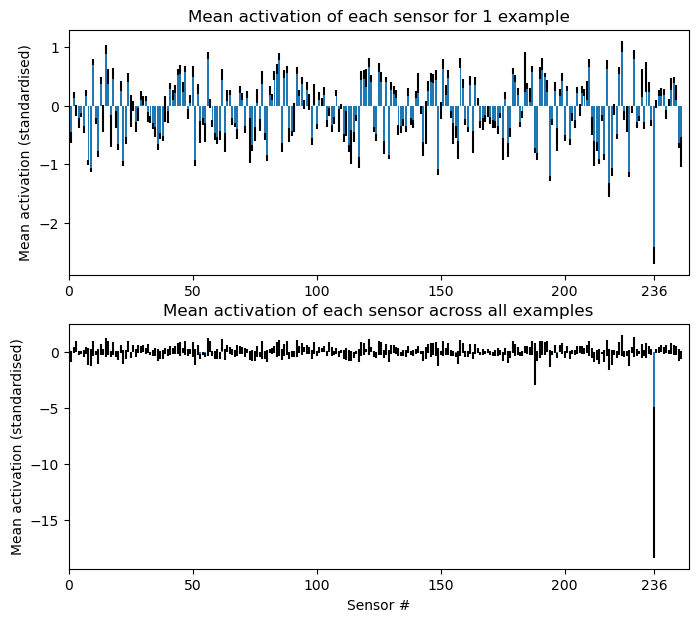

Sensors with absolute mean >1.5: (array([236]),)


In [13]:
plot_activations(train_intra_X)

In [24]:
train_intra_X = np.delete(train_intra_X, 236, axis=1)
test_intra_X = np.delete(test_intra_X, 236, axis=1)

In [25]:
from sklearn.decomposition import PCA

def perform_pca(data: np.ndarray, n_components = None):
    reshaped = data.reshape(-1, data.shape[-1])
    
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(reshaped)

    return pca, principal_components

In [26]:
pca_results, pca_components = perform_pca(train_intra_X, n_components=10)

In [27]:
print(f"Explained variance: {np.sum(pca_results.explained_variance_ratio_):.5%}\n"
      f"Number of components: {pca_results.n_components_}")

Explained variance: 99.58021%
Number of components: 10


In [19]:
# 10   features, 99.580% variance explained
# 100  features, 99.825% variance explained
# 250  features, 99.905% variance explained
# 1000 features, 99.968% variance explained

In [28]:
def get_pca(data: np.ndarray, n_components=10):
    return PCA(n_components=n_components).fit(data)

In [29]:
def logistic_regression_pcad_train(X_train, y_train, n_components=10):
    # Reshape to 2D array, still keeping each column as a sample/feature, to be able to perform PCA. e.g. (32, 248, 35624) -> (32 * 248, 35624)
    reshaped_X_train = X_train.reshape(-1, X_train.shape[-1]).astype(np.float32)

    # Perform PCA on the reshaped data.
    pca = get_pca(reshaped_X_train, n_components=n_components)
    X_train_pcad = pca.transform(reshaped_X_train)
    
    # Shape to a 2D array adept to LogisticRegression, separating back into individual training points.
    # e.g. (32 * 248, 10) -> (32, 2480)
    reshaped_X_train = X_train_pcad.reshape(X_train.shape[0], -1)

    model = LogisticRegressionSklearn()
    model.fit(reshaped_X_train, y_train)

    return pca, model

In [30]:
def logistic_regression_pcad_test(X_test, y_test, pca, model) -> float:
    reshaped_X_val = X_test.reshape(-1, X_test.shape[-1]).astype(np.float32)
    X_val_pcad = pca.transform(reshaped_X_val)
    reshaped_X_val = X_val_pcad.reshape(X_test.shape[0], -1)

    return model.score(reshaped_X_val, y_test)

In [31]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn

def logistic_regression_pcad_run(X: np.ndarray, y: np.ndarray, n_splits=5, n_components=10):
    scores = []
    kfold = KFold(n_splits=n_splits, shuffle=True)
    
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        pca, model = logistic_regression_pcad_train(X_train, y_train, n_components)
        
        score = logistic_regression_pcad_test(X_val, y_val, pca, model)
        scores.append(score)

    return sum(scores) / len(scores), scores

In [32]:
result, scores = logistic_regression_pcad_run(train_intra_X[:, :, :2], train_intra_y, n_components=1)

In [34]:
print(f"Accuracy: {result:.1%}")

Accuracy: 100.0%
